<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3.0)

20.0

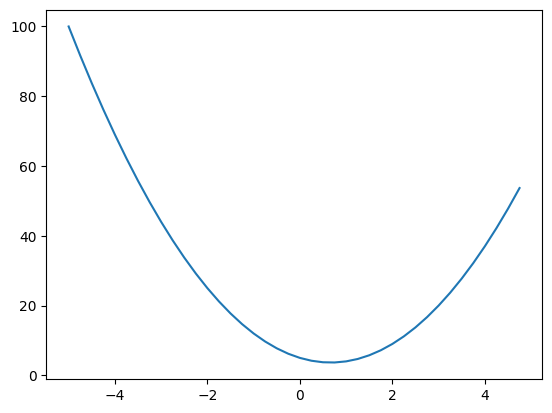

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

In [5]:
h = 0.001
x = 3.0
print(f(h + x))
print(f(h + x) - f(x))
print((f(h + x) - f(x)) / h)

20.014003000000002
0.01400300000000243
14.00300000000243


In [6]:
# More complex examples
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a += h
d2 = a*b + c
print(f'{d1=}; {d2=}')
print('slope: ', (d2 - d1 / h))

d1=4.0; d2=3.997
slope:  -3996.003


In [8]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

b += h
d2 = a*b + c
print(f'{d1=}; {d2=}')
print('slope: ', (d2 - d1 / h))

d1=4.0; d2=4.002
slope:  -3995.998


In [75]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label


  def __repr__(self):
    return f'Value(data = {self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    return out

    def __backward():
      self.grad += 1.0* out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other): #other + self
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad = other * self.data**(other - 1) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
              build_topo(child)
          topo.append(v)
    build_topo(o)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


Value(data = -8.0)

In [10]:
4 * a

Value(data = 8.0)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

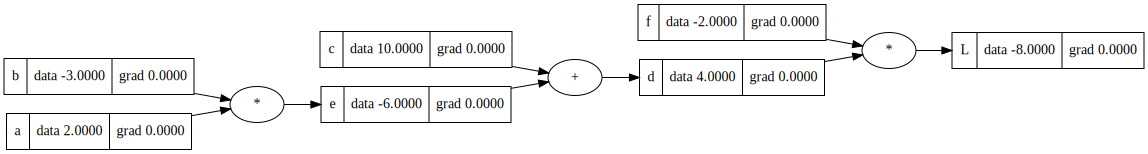

In [12]:
draw_dot(L)

Evidence for multiplication:

$\frac{f((d + h) * c) - f(d * c)} {h}$

$\frac{(cd + ch - cd)}{h}$

$\frac{ch}{h} = c $

Evidence for adding:

$\frac{f((d + h) + c) - f(d + c)}{h}$

$\frac{(d + h + c - d - c)}{h}$

$\frac{h}{h} = 1$

Chain rule:

$\frac{dL}{dd}$ $\times$ $\frac{dd}{de}$ = $\frac{dL}{de}$

In [13]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0 * 1 # dL/dd * dd/de
c.grad = -2.0
a.grad = -2.0 * 1 * -3.0 # dL/dd * dd/de * de/da
b.grad = -2.0 * 1 * 2.0 # dL/dd * dd/de * de/db


In [14]:
a.data += 0.01 * a.grad     # 0.01 as a learning rate
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.4352


In [15]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  a.data += h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print((L2-L1 / h))

lol()

7992.006


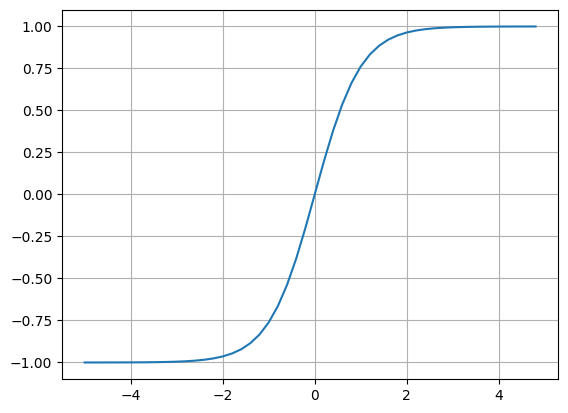

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

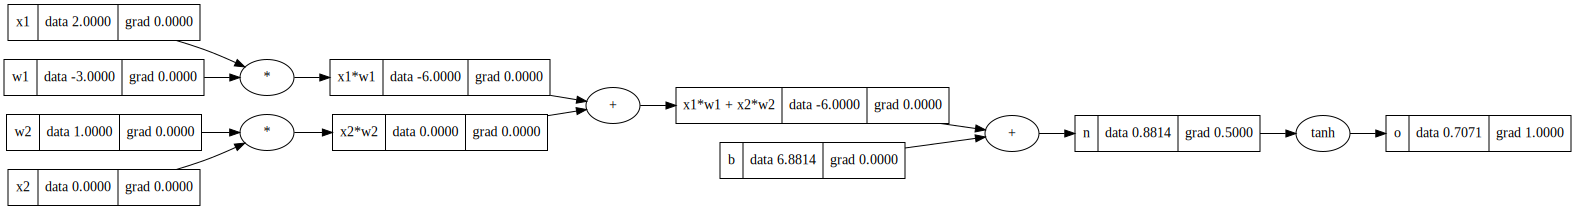

In [18]:
draw_dot(o)

In [19]:
1 - o.data**2

0.4999999999999999

In [21]:
#f(((w1 + h) * x1) - f(w1*x1)) / h
# (w1x1 + hx1 - w1x1) / h
# hx1 / h
# x1

In [22]:
# o.grad = 1.0
# n.grad  = 0.5
# b.grad = 0.5
# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad
# x2.grad = w2.data * x2w2.grad

In [23]:
o.grad = 1.0

In [24]:
o._backward()

In [25]:
n._backward()

In [26]:
b._backward()

In [27]:
x1w1x2w2._backward()

In [28]:
x2w2._backward()
x1w1._backward()

In [29]:
x1._backward()
x2._backward()
w1._backward()
w2._backward()

In [30]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


for node in reversed(topo):
    node._backward()

In [31]:
import torch

In [35]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [64]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.8715673958406392)

In [40]:
x = [2.0, 1.0]
n = Neuron(2)
n(x)

Value(data = -0.3860985445533386)

In [43]:
x = [2.0, 1.0]
n = Layer(2,3)
n(x)

[Value(data = -0.8783120137359327),
 Value(data = -0.6641206879716923),
 Value(data = -0.9559029622781152)]

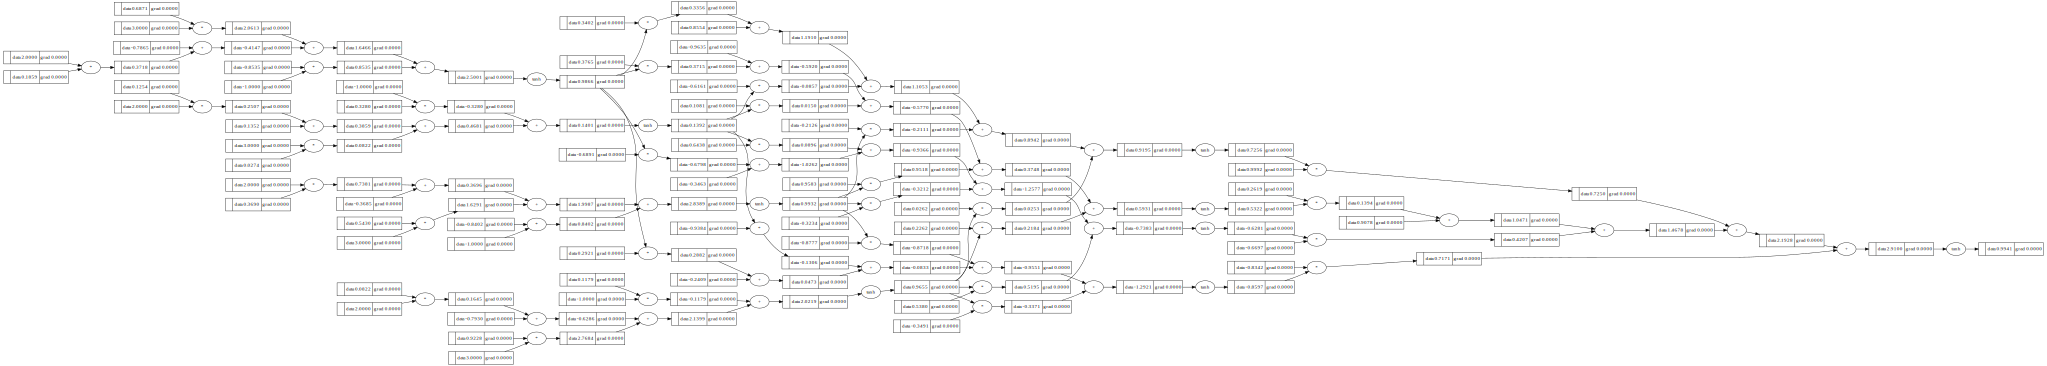

In [46]:
draw_dot(n(x))

In [76]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data = -0.8715673958406392),
 Value(data = -0.848560691008844),
 Value(data = -0.8695158667119964),
 Value(data = -0.7886664933922607)]

In [80]:
loss = [((yout - ygt)**2).data for ygt, yout in zip(ys, ypred)]
sum(loss)

6.742052315105518

In [82]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

In [84]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
    loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  print(k, loss.data)

AttributeError: 'Tensor' object has no attribute '_prev'